## Modeling
### Experiments with Tree-based Scikit-learn models

**Objective**: The primary objective of this notebook is to perform experimentation with the tree-based models for multi-step ahead forecasting.



In [2]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # Use __file__ for portability

# Move up one level to the project root
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Change working directory
os.chdir(project_root)

# Verify the change
print(os.getcwd()) 

/home/michel/projects/tree-based-forecasting-boilerplate


In [3]:
%load_ext autoreload
%autoreload 2

from scripts.run_wfv import *
from src.models.train_model import *
from src.models.evaluate_model import *
from src.models.predict_model import *
from src.visualization.data_viz import *

In [7]:
feature_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, PROCESSED_DATA_NAME), parse_dates=["DATE"])
cv_results_default = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, 'default_wfv_validation_results.csv'), parse_dates=["DATE"])
cv_results_tuned = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, 'tuned_wfv_validation_results.csv'), parse_dates=["DATE"])
# feature_df = feature_df[feature_df[CATEGORY_COL].isin(ticker_list)]

In [11]:
default_metrics = cv_results_default.groupby("TICKER").agg({"RMSE": "mean", "MAPE": "mean", "TRAINING_MAPE": "mean", "TRAINING_RMSE": "mean"})
default_metrics.sort_values("RMSE")

,RMSE,MAPE,TRAINING_MAPE,TRAINING_RMSE
TICKER,,,,
TAEE4.SA,0.141111,0.010733,0.004878,0.053889
BCFF11.SA,0.162222,0.017444,0.005494,0.044444
BRSR6.SA,0.246111,0.018911,0.007344,0.102222
CSMG3.SA,0.451667,0.019433,0.009100,0.138889
BBSE3.SA,0.567222,0.015561,0.005983,0.172222
EGIE3.SA,0.700000,0.014883,0.004517,0.207222
PETR4.SA,1.343333,0.031817,0.014094,0.225556
BOVA11.SA,1.605000,0.011850,0.004644,0.622778


In [13]:
tuned_metrics = cv_results_tuned.groupby("TICKER").agg({"RMSE": "mean", "MAPE": "mean", "TRAINING_MAPE": "mean", "TRAINING_RMSE": "mean"})
tuned_metrics.sort_values("RMSE")

,RMSE,MAPE,TRAINING_MAPE,TRAINING_RMSE
TICKER,,,,
TAEE4.SA,0.146111,0.011428,0.010822,0.122222
BCFF11.SA,0.148333,0.015811,0.005806,0.053333
BRSR6.SA,0.212778,0.016233,0.016444,0.227778
CSMG3.SA,0.421667,0.018044,0.011750,0.183889
EGIE3.SA,0.522222,0.010989,0.007061,0.336667
BBSE3.SA,0.535556,0.014717,0.009711,0.286111
PETR4.SA,1.176111,0.026611,0.027144,0.446667
BOVA11.SA,1.229444,0.008722,0.007439,1.032778


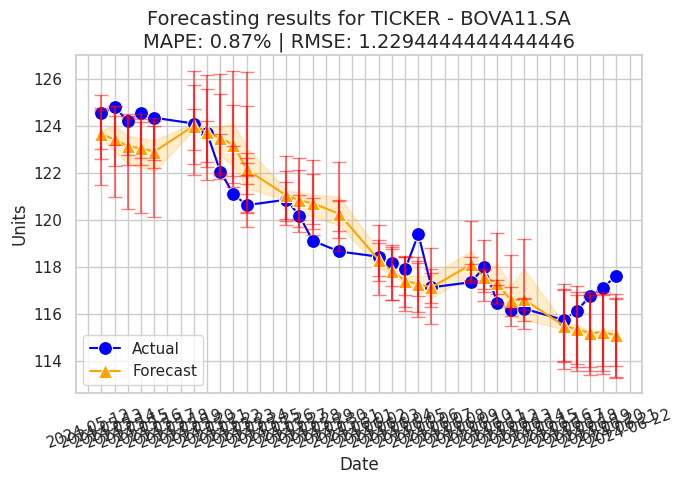

In [17]:
visualize_validation_results(cv_results_tuned[cv_results_tuned['TICKER'] ==data_config["ticker_list"][0] ], data_config["ticker_list"][0])

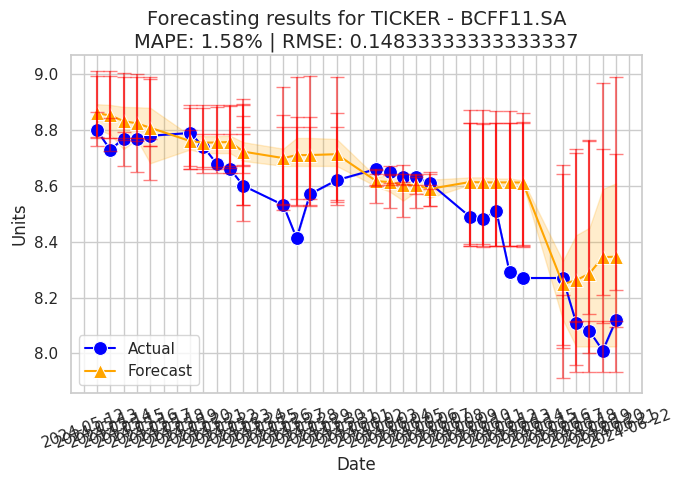

In [18]:
visualize_validation_results(cv_results_tuned[cv_results_tuned['TICKER'] ==data_config["ticker_list"][1] ], data_config["ticker_list"][1])

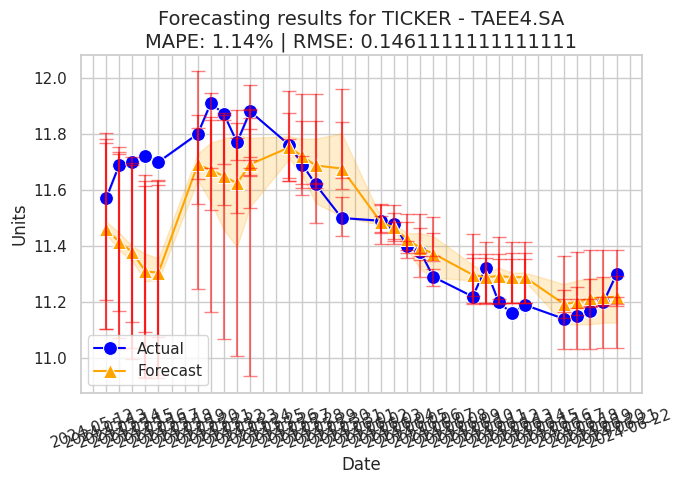

In [23]:
visualize_validation_results(cv_results_tuned[cv_results_tuned['TICKER'] == data_config["ticker_list"][2]], data_config["ticker_list"][2])

In [44]:
90 // 5

18

In [47]:
cv_results_default[cv_results_default['TICKER'] == data_config["ticker_list"][2]]

,DATE,ACTUAL,FORECAST,MAPE,MAE,WAPE,RMSE,MODEL_TYPE,CLASS,TRAINING_MAPE,TRAINING_RMSE,TICKER,TRAINING_DATE
180,2024-05-13,11.57,11.507608,0.0120,0.14,0.01,0.15,XGBRegressor,Testing,0.0017,0.02,TAEE4.SA,2024-06-23
181,2024-05-14,11.69,11.552718,0.0120,0.14,0.01,0.15,XGBRegressor,Testing,0.0017,0.02,TAEE4.SA,2024-06-23
182,2024-05-15,11.70,11.575998,0.0120,0.14,0.01,0.15,XGBRegressor,Testing,0.0017,0.02,TAEE4.SA,2024-06-23
183,2024-05-16,11.72,11.564269,0.0120,0.14,0.01,0.15,XGBRegressor,Testing,0.0017,0.02,TAEE4.SA,2024-06-23
184,2024-05-17,11.70,11.477134,0.0120,0.14,0.01,0.15,XGBRegressor,Testing,0.0017,0.02,TAEE4.SA,2024-06-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2024-06-17,11.14,11.242032,0.0071,0.08,0.01,0.08,AdaBoostRegressor,Testing,0.0128,0.14,TAEE4.SA,2024-06-23
266,2024-06-18,11.15,11.248938,0.0071,0.08,0.01,0.08,AdaBoostRegressor,Testing,0.0128,0.14,TAEE4.SA,2024-06-23
267,2024-06-19,11.17,11.263031,0.0071,0.08,0.01,0.08,AdaBoostRegressor,Testing,0.0128,0.14,TAEE4.SA,2024-06-23
268,2024-06-20,11.20,11.263031,0.0071,0.08,0.01,0.08,AdaBoostRegressor,Testing,0.0128,0.14,TAEE4.SA,2024-06-23


In [52]:
pred_df = cv_results_default[(cv_results_default['TICKER'] == data_config["ticker_list"][2])
                            & (cv_results_default["MODEL_TYPE"] == 'AdaBoostRegressor')]

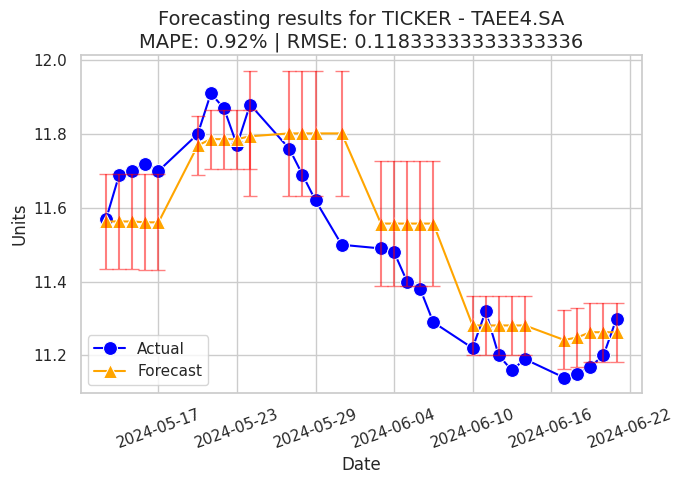

In [59]:
visualize_validation_results(pred_df, data_config["ticker_list"][2])